In [ ]:
#for parsing Genbank files.  Does these things:
#finds and reads a gb file stored on local drive
#makes a list of gene orientations, names, start, end, size and a dummy variable
#makes a codon usage table, but it ignores start and stop codons
#plots codon numbers vs. codon frequencies -- should give a straight line
#allows searches for genes

genomeFileName = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.sequence.2.gb'
codonTableName = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.CodonTable.txt'

import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
with open(genomeFileName, 'r') as gbfile:
  data = gbfile.read()
gbfile.close()
txtfile = str(data)
start = 3
stop = 3
frame = 0

# COLLECTS ALL THE GENES IN A LIST CALLED "features" AND THE SEQUENCE WILL BE IN split2[1]

split1 = txtfile.split('FEATURES') # split1[0] is annotations, split1[1] is the good stuff
split2 = split1[1].split('ORIGIN')  # gene locations are in split2[0] and genome sequence is in split2[1]
features = split2[0].split('  gene  ')  # separates each gene location and puts them in a list

seq = ''
for char in split2[1]:                  #puts sequence in a single, long string
    if char in ('t', 'g', 'c', 'a'):
        seq += char
        
print('The number of genes in "Features" =', len(features) -1)
print('The "sub-1" Features line starts with:', features[1][:100])
print('The first 100 nucleotides =', seq[:100])        

#COLLECT ALL THE FORWARD AND REVERSE GENES and labels them as 'FOR' or 'REV'
names =[]
forward =0
reverse =0

for x in range(1, len(features)):
  if 'join' not in features[x]:
    if 'complement' not in features[x]: genedirection = 'FOR'
    elif 'complement' in features[x]:   genedirection = 'REV'
    cleanfeatures = features[x].replace('complement(','').replace(')', '')\
    .replace('/', '').replace(' ', '').replace('gene="', '').replace('"', '')
    workgene = cleanfeatures.split('\n')
    genename = workgene[1]
    genelocation = workgene[0].split('.')
    genestart = genelocation[0] 
    geneend = genelocation[2] 
    genedata = [genedirection, genename, genestart, geneend, 0, 0.0]
    names.append(genedata)
              
#converts gene starts and ends to integers.  Calulates gene length
print('The number of annotated genes =', len(names))
for y in range(len(names)):
  try:
    names[y][2] = int(names[y][2])
    names[y][3] = int(names[y][3])
    names[y][4] = int(names[y][3]) - int(names[y][2])
  except: print('Bad gene:', names[y])
                  
genes =[]
for x in range(len(names)):
  if names[x][0] == 'FOR':
    cds = seq[names[x][2] -1 : names[x][3]]
  elif names[x][0] == 'REV':
    transposed = ''
    flipped = seq[names[x][2] -1 : names[x][3]]
    for char in flipped:
      if char == 'a': newchar = 't'
      elif char == 't': newchar = 'a'
      elif char == 'c': newchar = 'g'
      elif char == 'g': newchar = 'c'
      transposed += newchar
    cds = transposed[::-1]
  genes.append(cds)

#collects only those sequences that have proper start codons
startgenes =[]
startnames =[]
for x in range(len(genes)):
  firstcodon = genes[x][0:3]
  if firstcodon in ('atg', 'gtg', 'ctg', 'ttg', 'att', 'ata', 'aaa'):
    startgenes.append(genes[x])
    startnames.append(names[x])

#Collects only those sequences that do not contain internal stop codons
goodgenes =[]
goodnames =[]
for x in range(len(startgenes)):
  delete = False
  for a in range(start, len(startgenes[x]) - stop):
    if a % 3 == frame and delete == False:
      codon = startgenes[x][a:a+2] 
      if codon in ('tag', 'taa', 'tga'):
        delete = True
  if delete == False : 
    goodgenes.append(startgenes[x])
    goodnames.append(startnames[x])    

print('The number of good genes =', len(goodnames))

codons = ['ttt','ttc','tta','ttg', 'ctt','ctc','cta','ctg', 'att','atc','ata','atg', 'gtt','gtc','gta','gtg',\
          'tct','tcc','tca','tcg', 'cct','ccc','cca','ccg', 'act','acc','aca','acg', 'gct','gcc','gca','gcg',\
          'tat','tac','taa','tag', 'cat','cac','caa','cag', 'aat','aac','aaa','aag', 'gat','gac','gaa','gag',\
          'tgt','tgc','tga','tgg', 'cgt','cgc','cga','cgg', 'agt','agc','aga','agg', 'ggt','ggc','gga','ggg']

counts =[]
for x in range(len(codons)):
  counts.append(0)

for x in range(len(goodgenes)):
    for a in range(start, len(goodgenes[x]) -stop): 
        if a % 3 == frame  :
            codon = goodgenes[x][a:a+3] 
            for b in range(len(codons)):
                if codons[b] == codon: counts[b] += 1  

#CALCULATE PERCENTAGES OF EACH CODON
totalcodons =0
frequency =[]
for x in range(len(codons)):
    totalcodons += counts[x]
totalcodons -= 2 * len(goodgenes) #subtracts 2 from each gene, one each for start and stop codons
print( 'Total codons =', totalcodons )

print('The number of annotated genes =',len(genedata), ', the number of goodgenes =', len(goodgenes))
#make a codon table
codontable =[]
outtable =[]
for x in range(len(codons)):
  codontable.append([codons[x], counts[x], float(counts[x]) / float(totalcodons)])
  print(codons[x], ', ', counts[x], ', ', float(counts[x]) / float(totalcodons))
  outtable.append(str(codons[x]) +','+ str(counts[x]) +','+ str(float(counts[x]) / float(totalcodons)) +'\n')
  
with open(codonTableName, 'w') as g:
  for x in range(len(outtable)):
    g.write(outtable[x])
g.close()
print('Table written to file:', codonTableName)
  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The number of genes in "Features" = 4566
The "sub-1" Features line starts with:           190..255
                     /gene="thrL"
                     /locus_tag="b0001"
       
The first 100 nucleotides = agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat
The number of annotated genes = 4546
The number of good genes = 4175
Total codons = 1273615
The number of annotated genes = 6 , the number of goodgenes = 4175
ttt ,  28721 ,  0.022550770837340955
ttc ,  21250 ,  0.016684790929755066
tta ,  18103 ,  0.01421387153888734
ttg ,  17565 ,  0.013791451890877542
ctt ,  14405 ,  0.011310325333793964
ctc ,  14418 ,  0.011320532500009814
cta ,  5100 ,  0.004004349823141217
ctg ,  67754 ,  0.05319817998374705
att ,  39189 ,  0.030769895140996296
atc ,  32432 ,  0.02546452420865018
ata ,  5764 ,  0.00452570046678156

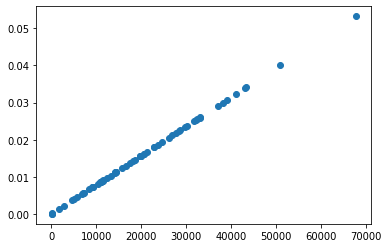

In [ ]:
xp =[]
yp =[]
for x in range(len(codontable)):
  xp.append(codontable[x][1])
  yp.append(codontable[x][2])
plt.scatter(xp, yp)
plt.show()

In [ ]:
genes =['prf'] #set of genes to look for
print('gene#, direction, name, start, end, length')
for x in range(len(genes)):
  a = genes[x]
  for y in range(len(goodnames)):
    if a in goodnames[y][1]:
      print(y, goodnames[y][:-1])

gene#, direction, name, start, end, length
219 ['FOR', 'prfH', 253702, 254202, 500]
1131 ['FOR', 'prfA', 1265012, 1266094, 1082]
4149 ['FOR', 'prfC', 4609414, 4611003, 1589]
